In [3]:
import re
import os
import pathlib
import json

import plotnine
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

In [4]:
experiment = "01_http_max_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()
results_dir

PosixPath('/home/richard/projects/mesh-bench/results/01_http_max_throughput')

In [56]:

from typing import List, TypedDict

# Represents a single data point of system utilization
class ResourceResult(TypedDict):
    mesh: str
    qps: str
    pod: str
    container: str
    time: int
    cpu: float
    mem: float



def parse_resource_results(result_file: pathlib.Path) -> List[ResourceResult]:
    """ Reads a result file and parses the data.

    The returned data is a list of ResourceResults that represent a
    single metric over a time span of 15 minutes.
    """
    rows = []

    # Regex to extra# 0 -> Full match
    # 1 -> mem/cpu results
    # 2 -> Mesh
    # 3 -> Requested QPS
    name_re = re.compile("^(mem|cpu)_([a-z]+)_(\d+|MAX).*json$")

    # Extract metadata from the result
    matches = name_re.match(file)

    metric = matches[1]
    mesh = matches[2]
    qps = matches[3]
    print(f"Type: {metric}, Mesh: {mesh}, QPS: {qps}")

    with open(result_file) as f:
        data = json.load(f)

    # The resutl is lister per pod/container
    for container in data:

        # Metadata (dimensions)
        meta = container["metric"]

        # Actual values in list[unixtime, value]
        values = container["values"]

        for v in values:
            row: ResourceResult = {
                "mesh": mesh,
                "qps": qps,
                "pod": meta["pod"],
                "container": meta["container"],
                "time": v[0],
                metric: v[1],
            }
            rows.append(row)

    return rows


In [58]:
"""
Generate a list of rows containing a single metric (either cpu or mem)
These later have to be merged based on time
"""


results = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Skip non system resource files
        if not re.match("^(mem|cpu).*$", file):
            continue

        
        path = (pathlib.Path(root) / file).resolve()
        res = parse_resource_results(path)
        results.extend(res)

results

Parsing Experiment results:
Exp: 01_http_max_throughput
Results: 15
Type: cpu, Mesh: istio, QPS: MAX
Type: mem, Mesh: baseline, QPS: MAX
Type: mem, Mesh: istio, QPS: MAX
Type: cpu, Mesh: baseline, QPS: MAX
Type: mem, Mesh: linkerd, QPS: MAX
Type: mem, Mesh: traefik, QPS: MAX
Type: cpu, Mesh: cilium, QPS: MAX
Type: cpu, Mesh: traefik, QPS: MAX
Type: cpu, Mesh: linkerd, QPS: MAX
Type: mem, Mesh: cilium, QPS: MAX


[{'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275944,
  'cpu': '0.044302137147215044'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275947,
  'cpu': '0.048305848894251116'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275950,
  'cpu': '0.052309560641287195'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275953,
  'cpu': '0.05631327238832328'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275956,
  'cpu': '0.060316984135359346'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'target-fortio-746f85d498-vv4vf',
  'container': 'fortio',
  'time': 1656275959,
  'cpu': '0.06432069588239543'},
 {'mesh': 'istio',
  'qps': 'MAX',
  'pod': 'tar

In [148]:
""" Create a pandas DataFrame
- Each row represents a single observation
- Each observation takes a form of type ResourceResult
- Rows are merged based on time/pod/container -> this halves rows as both CPU/mem metrics share unix timestamps
- Convert unix timestamps to pd.DateTime
"""


# Initial dataset
df = pd.DataFrame(data=results)

# Merged CPU/mem results
df = df.groupby(by=["mesh", "qps", "pod", "container", "time"], as_index=False).first()

# Convert time column to datetime
df["date"] = pd.to_datetime(df["time"],unit="s")
df["cpu"] = pd.to_numeric(df["cpu"])
df["mem"] = pd.to_numeric(df["mem"])

df




,mesh,qps,pod,container,time,cpu,mem,date,delta
0,baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,1656253918,0.000719,1072.776342,2022-06-26 14:31:58,0 days 00:00:00
1,baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,1656253921,0.000719,1072.776342,2022-06-26 14:32:01,0 days 00:00:03
2,baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,1656253924,0.049509,18820.872955,2022-06-26 14:32:04,0 days 00:00:06
3,baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,1656253927,0.063200,24103.189715,2022-06-26 14:32:07,0 days 00:00:09
4,baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,1656253930,0.063200,24103.189715,2022-06-26 14:32:10,0 days 00:00:12
...,...,...,...,...,...,...,...,...,...
3296,traefik,MAX,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656322050,0.199043,7940.927823,2022-06-27 09:27:30,0 days 18:55:32
3297,traefik,MAX,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656322053,0.164268,401269.926728,2022-06-27 09:27:33,0 days 18:55:35
3298,traefik,MAX,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656322056,0.169244,413426.019672,2022-06-27 09:27:36,0 days 18:55:38
3299,traefik,MAX,traefik-mesh-proxy-vrsrx,traefik-mesh-proxy,1656322059,0.199054,486243.717761,2022-06-27 09:27:39,0 days 18:55:41


<AxesSubplot:xlabel='timepoint', ylabel='signal'>

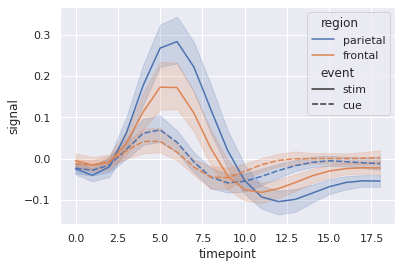

In [80]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

In [82]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


In [102]:
df.dtypes

mesh                 object
qps                  object
pod                  object
container            object
time         datetime64[ns]
cpu                 float64
mem                 float64
dtype: object

In [150]:
subset=df[df['mesh'] == 'traefik']
subset['delta'] = subset.date - subset.date.min()
subset.head()

/tmp/ipykernel_21134/1878982185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mesh,qps,pod,container,time,cpu,mem,date,delta
2699,traefik,MAX,target-fortio-746f85d498-tf82p,fortio,1656321162,0.023718,88684.62039,2022-06-27 09:12:42,0 days 00:00:00
2700,traefik,MAX,target-fortio-746f85d498-tf82p,fortio,1656321165,0.023718,88684.62039,2022-06-27 09:12:45,0 days 00:00:03
2701,traefik,MAX,target-fortio-746f85d498-tf82p,fortio,1656321168,0.023718,88684.62039,2022-06-27 09:12:48,0 days 00:00:06
2702,traefik,MAX,target-fortio-746f85d498-tf82p,fortio,1656321171,0.023718,88684.62039,2022-06-27 09:12:51,0 days 00:00:09
2703,traefik,MAX,target-fortio-746f85d498-tf82p,fortio,1656321174,0.023718,88684.62039,2022-06-27 09:12:54,0 days 00:00:12


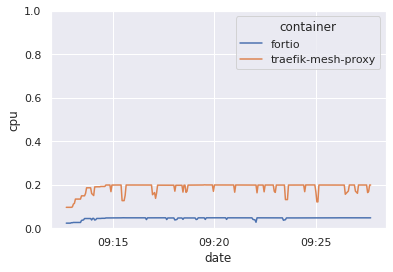

In [203]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator)
fig, ax = plt.subplots()

# Plot the responses for different events and regions
sns.lineplot(
    data=subset,
    x="date",
    y="cpu",
    hue="container",
    # style="pod",
    ax=ax)


ax.set_ylim(bottom=0, top=1)   
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

In [227]:
import matplotlib
import matplotlib.ticker as ticker


def plot_resource_usage(ax: matplotlib.axes, data: pd.DataFrame) -> matplotlib.axes:
    """Plots the resource utilization on a given axes.

    y1: CPU usage in fractios of a CPU core per second
    y2: Mem usage in bytes
    x: date
    """

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=subset, x=time_delta, y="cpu", hue="container", ax=ax)

    mesh = data["mesh"].iloc[0].capitalize()
    qps = data["qps"].iloc[0].capitalize()

    # Labels
    plot_title = (
        f"$\\bf{mesh}$\n"
        f"RPS: {qps}\n"
    )
    ax.set_ylabel("CPU usage")
    ax.set_xlabel("Time")
    ax.set_title(plot_title, y=1.05)

    # X axis label formatting
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax.set_xticklabels([0, 5, 15])

    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.minorticks_on()

    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # # Create another axes that shares the x axis
    # ax2 = ax.twinx()
    # ax2.set_alpha(0.5)
    # ax2.grid(False)

    # sns.lineplot(data=subset, x="date", y="mem", hue="container", ax=ax2)

    return ax

subset=df[df['mesh'] == 'traefik']

fig, ax = plt.subplots()
plot_resource_usage(ax, subset)

fig.show()


/tmp/ipykernel_21134/2412510408.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


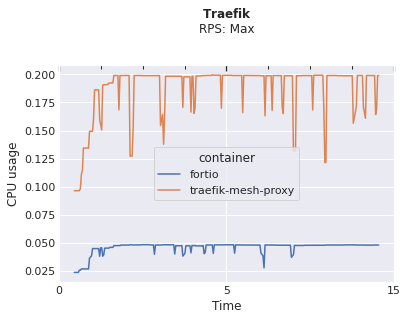